ECO6193/6593 - Assignment 1/Devoir 1. Solutions for part 2 (unemployment cyclical decomposition based on LFS unemployment duration data for Canada, 1976)

In [1]:
# modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp


Import raw data collected from Cansim (LFS population estimates). Series: - labour force (v2062810); unemployment (v2062814); unemployment 1 to 4 weeks (v1078667742). All series are in person units and seasonally adjusted.

In [2]:
# show directory path
os.getcwd()

# import local files for raw data
df = pd.read_csv('cansim_data.txt', header = 9, index_col=0, parse_dates=True, sep = ',', names = ['l_t', 'u_t', 'us_t'])

# compute unemployment rate
df['ur_t'] = df['u_t']/df['l_t']


Compute monthly transition probabilities using Shimer (2012) method. First, compute $F_t$ the job-finding probability (monthly UE probability).

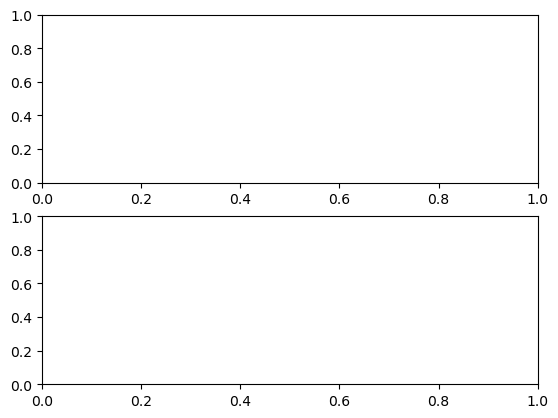

In [3]:
# Job finding probabililty

# compute lead of unemployment population
df['u_{t+1}'] = df['u_t'].shift(-1)
df['us_{t+1}'] = df['us_t'].shift(-1)

# compute job finding probability
df['F_t'] = 1 - ( df['u_{t+1}'] - df['us_{t+1}'] ) / df['u_t']

# job finding probability
[fig, ax] = plt.subplots(2)

# job-finding rate
df['f_t'] = - np.log(1 - df['F_t'])

# keep sample where unemployment duration is not missing
df = df.loc[~ df['us_t'].isna() ]


Compute $S_t$, the job separation probability

In [4]:
# define function of t to solve for s_t
def g(t, s, df):

    df = df.loc[df.index == t]

    f = df['f_t']
    l = df['l_t']
    u = df['u_t']
    u_lead = df['u_{t+1}']
    u_ss = s / (s + f)

    return u_lead - u_ss * l + np.exp( -(s+f)  ) * (u - u_ss * l) 


In [5]:
# initial variable
df['s_t'] = np.nan

# diagnostic
df['obj'] = np.nan

# iterate over time to find s_t
for t in df.index[:-1]:

    # show date
    print(t)
    
    # initial guess
    s0 = 0.03

    # objective function
    f = lambda s: g(t, s, df)

    # evaluate objective function
    print(f(s0))

    # solve for s_t
    s_t = sp.optimize.fsolve(f, s0)

    # show solution objective
    print([s_t, f(s_t)])

    # stack s_t in dataframe
    df.loc[df.index == t, 's_t'] = s_t
    df.loc[df.index == t, 'obj'] = f(s_t)

# compute the job separation probability
df['S_t'] = 1 - np.exp( - df['s_t'] )


2002-01-01 00:00:00
2002-01-01    354919.700886
dtype: float64
[array([0.03652238]), 2002-01-01   -7.821654e-11
dtype: float64]
2002-02-01 00:00:00
2002-02-01    345895.720403
dtype: float64
[array([0.03636714]), 2002-02-01    6.818937e-10
dtype: float64]
2002-03-01 00:00:00
2002-03-01    422662.974307
dtype: float64
[array([0.03839787]), 2002-03-01   -2.437446e-10
dtype: float64]
2002-04-01 00:00:00
2002-04-01    335379.580569
dtype: float64
[array([0.03625683]), 2002-04-01   -9.094947e-11
dtype: float64]
2002-05-01 00:00:00
2002-05-01    364812.876815
dtype: float64
[array([0.03700893]), 2002-05-01    2.473826e-10
dtype: float64]
2002-06-01 00:00:00
2002-06-01    287324.384217
dtype: float64
[array([0.03524538]), 2002-06-01    2.149318e-08
dtype: float64]
2002-07-01 00:00:00
2002-07-01    423096.358396
dtype: float64
[array([0.03870245]), 2002-07-01   -2.055458e-10
dtype: float64]
2002-08-01 00:00:00
2002-08-01    343260.825711
dtype: float64
[array([0.03662813]), 2002-08-01   -9.458

Compute cyclical variables.

In [6]:
# compute quarterly averages
dfq = df[ ['ur_t', 'S_t', 's_t', 'F_t', 'f_t'] ].resample('Q').mean()

# HP trends
import statsmodels.tsa.filters.hp_filter as hp

# hp trends
dfq['S_t_trend'] = hp.hpfilter(dfq['S_t'], lamb = 1600)[1]
dfq['s_t_trend'] = hp.hpfilter(dfq['s_t'], lamb = 1600)[1]
dfq['F_t_trend'] = hp.hpfilter(dfq['F_t'], lamb = 1600)[1]
dfq['f_t_trend'] = hp.hpfilter(dfq['f_t'], lamb = 1600)[1]

# log cyclical components
dfq['S_t_cyc'] = np.log( dfq['S_t'] / dfq['S_t_trend'] )
dfq['s_t_cyc'] = np.log( dfq['s_t'] / dfq['s_t_trend'] )
dfq['F_t_cyc'] = np.log( dfq['F_t'] / dfq['F_t_trend'] )
dfq['f_t_cyc'] = np.log( dfq['f_t'] / dfq['f_t_trend'] )

Plots: job separation and job finding monthly probabilities (cyclical component).

Text(0.5, 1.0, 'Monthly Job finding probability (cyclical)')

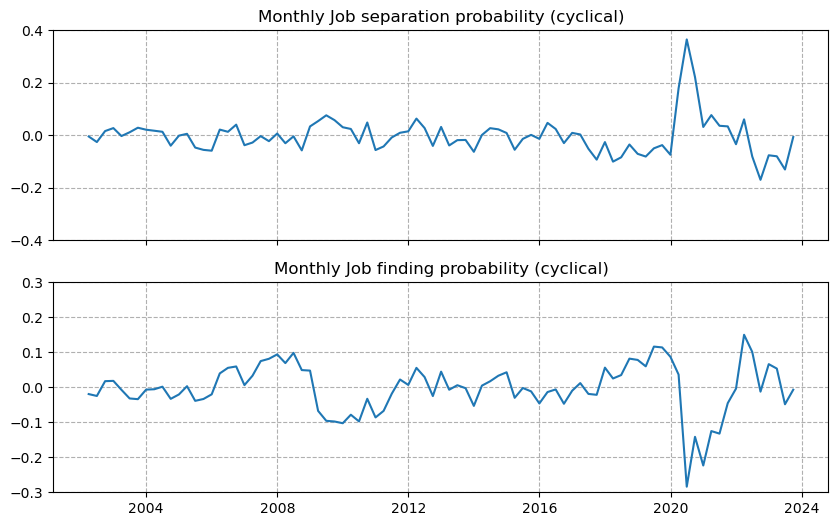

In [7]:

fig, axs = plt.subplots(2, sharex=True, figsize = (10, 6) )

axs[0].plot( dfq['S_t_cyc'] )
axs[0].grid(True, linestyle = '--')
axs[0].set_ylim(-0.4, 0.4 )
axs[0].set_title('Monthly Job separation probability (cyclical)')


axs[1].plot( dfq['F_t_cyc'] )
axs[1].grid(True, linestyle = '--')
axs[1].set_ylim(-0.3, 0.3 )
axs[1].set_title('Monthly Job finding probability (cyclical)')


Plot the actual unemployment rate vs. the steady-state unemployment cyclical component.

Correlation = 
0.9838366422605804


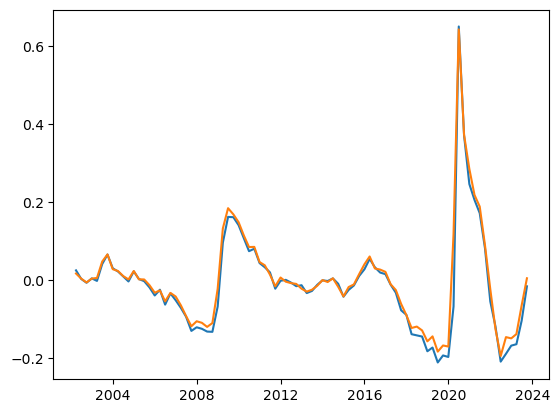

In [8]:
# actual unemployment rate
ur = dfq['ur_t']  

# cyclical component of unemployment rate
ur_cyc = np.log( ur / hp.hpfilter(ur, lamb = 1600)[1] )

# steady-state
ur_ss = dfq['s_t'] / (dfq['s_t'] + dfq['f_t'])

# trend (à la Fujita, Ramey (2009))
ur_ss_bar = dfq['s_t_trend'] / ( dfq['s_t_trend'] + dfq['f_t_trend'] )

# cyclical component of steady-state unemployment rate
ur_ss_cyc = np.log( ur_ss / ur_ss_bar )

# plot
plt.plot(ur_cyc, label = 'Actual unemployment rate')
plt.plot(ur_ss_cyc, label = 'Steady-state unemployment rate')

# show correlation
print('Correlation = ')
print( np.corrcoef(ur_cyc, ur_ss_cyc)[0,1] )



Unemployment decomposition, based on Fujita, Ramey (2009). First, define the variables for components of cyclical unemployment.

In [9]:


# steady-state unemployment rate
u_ss = dfq['s_t'] / (dfq['s_t'] + dfq['f_t'])

# steady-state unemployment rate, trend
u_ss_bar = dfq['s_t_trend'] / (dfq['s_t_trend'] + dfq['f_t_trend'])

# unemployment component
dfq['du'] = np.log( u_ss / u_ss_bar )

# job separation component
dfq['ds'] = (1 - u_ss_bar) * np.log( dfq['s_t'] / dfq['s_t_trend'] )

# job finding component
dfq['df'] = - (1 - u_ss_bar) * np.log( dfq['f_t'] / dfq['f_t_trend'] )

# error term
dfq['error'] = dfq['du'] - dfq['ds'] - dfq['df']


Variance-covariance decomposition. One can define a function that take as argument a Dataframe and return a table with results. 

In [10]:
# cyclical unemployment variance decomposition 

# define a function to compute variance decomposition given dataframe
def u_decomp(dfq):

    # First, define Fujita, Ramey variables:

    # steady-state unemployment rate
    u_ss = dfq['s_t'] / (dfq['s_t'] + dfq['f_t'])

    # steady-state unemployment rate, trend
    u_ss_bar = dfq['s_t_trend'] / (dfq['s_t_trend'] + dfq['f_t_trend'])

    # unemployment component
    du = np.log( u_ss / u_ss_bar )

    # job separation component
    dsr = (1 - u_ss_bar) * np.log( dfq['s_t'] / dfq['s_t_trend'] )

    # job finding component
    djfr = - (1 - u_ss_bar) * np.log( dfq['f_t'] / dfq['f_t_trend'] )

    # error term
    err = du - djfr - dsr

    # variance-covariance matrix
    varcov = np.cov( [du, dsr, djfr, err] )

    # compute beta's (variance shares)
    beta_jfr = varcov[0, 2] / varcov[0, 0]
    beta_sr = varcov[0, 1] / varcov[0, 0]
    residual = varcov[0, 3] / varcov[0, 0]
    
    # build a list
    list = [beta_jfr, beta_sr, residual]

    # build a table with results
    table = pd.DataFrame(list, index = ['beta_jfr', 'beta_sr', 'residual'], columns = ['variance_share'])

    return [table, varcov]

Perform the decomposition on the full sample and show the results in a table:

In [11]:
# variance decomposition, from 2000 to 2023
print('Cyclical unemployment decompositon, from 2000 to 2023:')
[tab, varcov] = u_decomp(dfq)
tab


Cyclical unemployment decompositon, from 2000 to 2023:


,variance_share
beta_jfr,0.582935
beta_sr,0.429010
residual,-0.011945


Do the same, but using pre-COVID data:

In [12]:
# select data from 2000 to 2019
dfq_pre = dfq.loc['2000-01-01':'2019-12-01', :]

# variance decomposition, from 2000 to 2019
[tab_pre, varcov_pre] = u_decomp(dfq_pre)
print('Cyclical unemployment decompositon, from 2000 to 2019:')
tab_pre


Cyclical unemployment decompositon, from 2000 to 2019:


,variance_share
beta_jfr,0.701029
beta_sr,0.298782
residual,0.000189
